In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import shap

### **Importing Training/Testing Features and Labels Data**


*   80/20 train-test split

*   Each sample is a 64 x 64 pixel grid (each pixel representing 1 km) for 8 layers of environmental raster variables:
    * Monthly Maximum Temperature
    * Monthly Minimum Temperature
    * Monthly Total Precipitation
    * Annual Glyphosate Use
    * Elevation
    * Nonforested Primary Land Cover
    * Agricultural Land Cover
    * Urban Land Cover






In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
X_train_spring = np.load('/content/drive/MyDrive/Train Test Data/X_train_spring.npy')
X_test_spring = np.load('/content/drive/MyDrive/Train Test Data/X_test_spring.npy')
y_train_spring = np.load('/content/drive/MyDrive/Train Test Data/y_train_spring.npy')
y_test_spring = np.load('/content/drive/MyDrive/Train Test Data/y_test_spring.npy')

In [7]:
X_train_spring = np.transpose(X_train_spring, (0, 2, 3, 1))
X_train_spring.shape

(2912, 64, 64, 8)

In [8]:
X_test_spring = np.transpose(X_test_spring, (0, 2, 3, 1))
X_test_spring.shape

(729, 64, 64, 8)

In [9]:
y_train_spring.shape

(2912,)

In [10]:
y_test_spring.shape

(729,)

### **Training the Convolutional Neural Network Species Distribution (CNN-SDM) Model**

In [11]:
model_spring = Sequential()

# Input layer: 64x64 spatial grid with 8 channels
model_spring.add(tf.keras.layers.Input(shape = (64, 64, 8)))

# First convolutional and pooling layer: Detect basic patterns with 16 filters
model_spring.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
model_spring.add(MaxPool2D(pool_size = (2, 2)))

# Second convolutional and pooling layer: Learn more complex patterns with 32 filters
model_spring.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model_spring.add(MaxPool2D(pool_size = (2, 2)))

# Flatten spatial features for dense classification layer
model_spring.add(Flatten())

# Output layer: Binary classification with sigmoid activation
model_spring.add(Dense(1, activation = 'sigmoid'))

# Compile model: Binary cross-entropy loss function, Adam adaptive learning optimization algorithm, performance metric tracking
model_spring.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy', tf.keras.metrics.Recall()])

# Display architecture summary: ~12,000 parameters
model_spring.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,081 (47.19 KB)

 Trainable params: 12,081 (47.19 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history_spring = model_spring.fit(X_train_spring, y_train_spring, epochs = 10, validation_data = (X_test_spring, y_test_spring))

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9128 - loss: 0.2108 - recall: 0.9694 - val_accuracy: 0.9767 - val_loss: 0.0686 - val_recall: 0.9924
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.9748 - loss: 0.0668 - recall: 0.9912 - val_accuracy: 0.9849 - val_loss: 0.0570 - val_recall: 0.9949
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9779 - loss: 0.0703 - recall: 0.9916 - val_accuracy: 0.9835 - val_loss: 0.0488 - val_recall: 0.9924
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.9821 - loss: 0.0551 - recall: 0.9923 - val_accuracy: 0.9822 - val_loss: 0.0412 - val_recall: 0.9823
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.9860 - loss: 0.0424 - recall: 0.9930 - val_accuracy: 0.9822 - val_loss: 0.0482 - val_recall: 0.9772
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9845 - loss: 0.0398 - recall: 0.9845 - val_accuracy: 0.9794 - val_loss: 0.0409 - val_recall: 0.9747


### **Evaluating Model Performance & Selecting Binary Classification Threshold**

<Axes: >

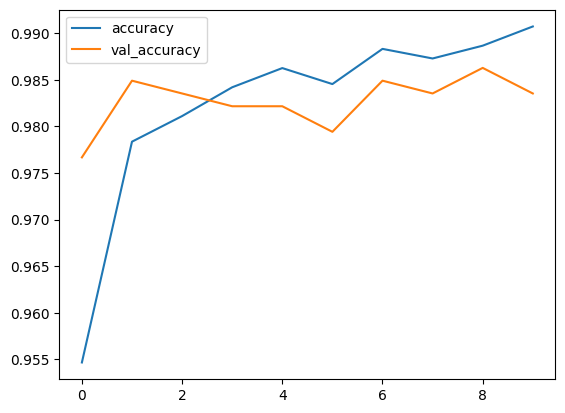

In [13]:
# Plots training and validation accuracy to assess learning trend and overfitting
losses_spring = pd.DataFrame(history_spring.history)
losses_spring[['accuracy', 'val_accuracy']].plot()

In [14]:
# Generates probability predictions on test set for model evaluation
y_pred_spring = model_spring.predict(X_test_spring)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [15]:
# Calculates false positive rate (FPR) and true positive rate (TPR) across classification thresholds
fpr_spring, tpr_spring, thresholds_spring = roc_curve(y_test_spring, y_pred_spring)

0.9984916243462442


/tmp/ipython-input-4227179212.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 'lower right')


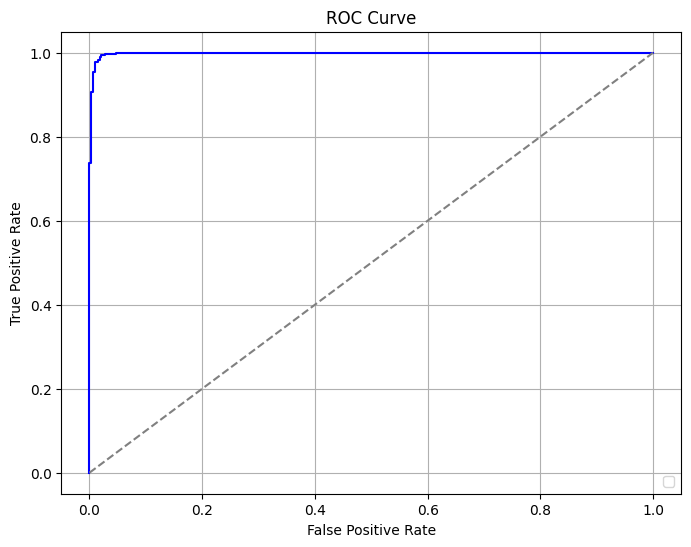

In [16]:
# Calculates the area under the Receiver Operating Characteristic curve (AUC-ROC; FPR vs TPR)
roc_auc_spring = auc(fpr_spring, tpr_spring)
print(roc_auc_spring) # AUC-ROC = 1 (perfect classifier); AUC-ROC = 0.5 (random classifer)

# Plots the ROC curve
plt.figure(figsize = (8, 6))
plt.plot(fpr_spring, tpr_spring, color='blue')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

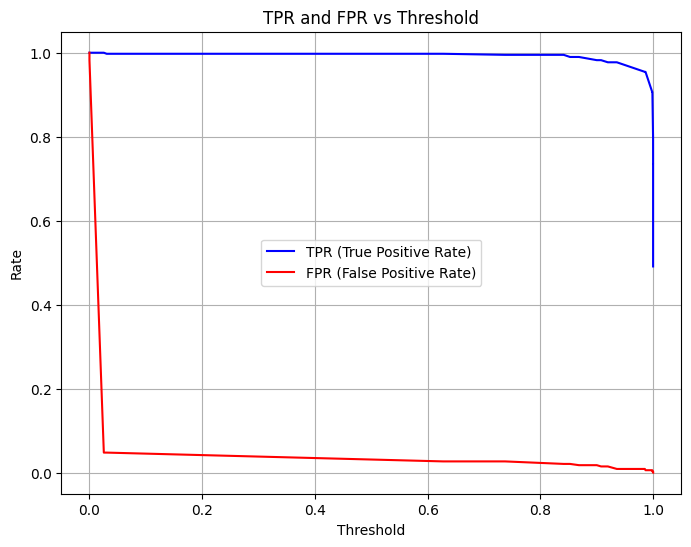

In [17]:
# Plots TPR and FPR against classification thresholds
plt.figure(figsize = (8, 6))
plt.plot(thresholds_spring, tpr_spring, label = 'TPR (True Positive Rate)', color = 'blue')
plt.plot(thresholds_spring, fpr_spring, label = 'FPR (False Positive Rate)', color = 'red')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('TPR and FPR vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Calculates the True Skill Statistic (TSS; TPR - FPR) to select the optimal threshold for binary classification
tss_spring = tpr_spring - fpr_spring
best_threshold_spring = thresholds_spring[np.argmax(tss_spring)]
best_tpr_spring = tpr_spring[np.argmax(tss_spring)]
best_fpr_spring = fpr_spring[np.argmax(tss_spring)]
print(best_threshold_spring) # TSS = 1 (perfect classifier); TSS = 0 (random guessing); TSS = -1 (perfectly wrong classifer)
print(best_tpr_spring) # TPR = percentage of positive cases predicting correctly
print(best_fpr_spring) # FPR = percentage of negative cases wrongly predicted as positive

0.84140104
0.9949367088607595
0.020958083832335328


### **Calculating Permutation Feature Importance**

In [19]:
# Compute the baseline accuracy score of the test dataset
baseline_preds = model_spring.predict(X_test_spring)
pred_labels = (baseline_preds >= best_threshold_spring).astype(int).flatten()
baseline = accuracy_score(y_test_spring, pred_labels)
print(baseline)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
0.9876543209876543


In [20]:
X_test_spring.shape

(729, 64, 64, 8)

In [21]:
# Variables of the 8 channels to label results
variable_names = ['Monthly Maximum Temperature', 'Monthly Minimum Temperature', 'Monthly Total Precipitation', 'Annual Glyphosate Use', 'Elevation', 'Nonforested Primary Land Cover', 'Agricultural Land Cover', 'Urban Land Cover']

# To collect mean and standard deviation (SD) of permutation importance of each channel
importances = []
importances_sd = []

# To store every permutation importance calculation with the variable and group for later plotting (see 'pi_analysis_bar_chart.ipynb')
results = {'Group': [], 'Variable': [], 'Permutation Importance': []}

# Calculate permutation importances 50 times for each variable
for channel in range(8):
  scores = []
  for _ in range(50):
    X_permuted = X_test_spring.copy()
    # Extracts the 64 x 64 grid of the current variable for all samples, and flatten into rows with 4096 (64 x 64) values, each row representing a sample
    flat_channel = X_permuted[:, :, :, channel].reshape(X_test_spring.shape[0], -1)

    # Shuffle/permute each row or sample
    np.random.shuffle(flat_channel)

    # Reshapes the samples back to 64 x 64 grids, and sets them as the new samples of the current variable in the model input tensor
    X_permuted[:, :, :, channel] = flat_channel.reshape(X_test_spring.shape[0], 64, 64)

    # Produce new predictions with the model using the permuted samples for the current variable
    preds = model_spring.predict(X_permuted)
    pred_labels = (preds >= best_threshold_spring).astype(int).flatten()

    # Calculate accuracy score of new predictions and calculate and record the performance drop
    score = accuracy_score(y_test_spring, pred_labels)
    results['Group'].append('Spring')
    results['Variable'].append(variable_names[channel])
    results['Permutation Importance'].append(baseline - score)
    scores.append(baseline - score)

  # store the mean and standard deviation of the permutation importance for each variable
  importances.append(np.mean(scores))
  importances_sd.append(np.std(scores))

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


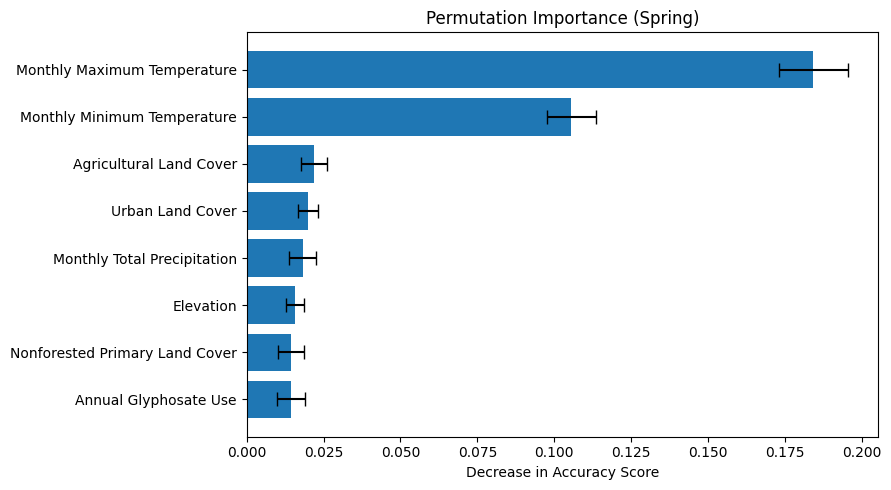

In [22]:
# Sort mean and SDs of permutation importances in ascending order
sorted_idx = np.argsort(importances)
importances_sorted = np.array(importances)[sorted_idx]
importances_sd_sorted = np.array(importances_sd)[sorted_idx]
variable_names_sorted = np.array(variable_names)[sorted_idx]

# Plot bar chart of the permutation importances for this model/group with error bars indicating SDs
plt.figure(figsize = (9, 5))
plt.barh(variable_names_sorted, importances_sorted, xerr = importances_sd_sorted, color = "tab:blue", capsize = 5)
plt.xlabel("Decrease in Accuracy Score")
plt.title("Permutation Importance (Spring)")
plt.tight_layout()
plt.show()

In [23]:
# Saves the CNN-SDM model for this group
model_spring.save("/content/drive/MyDrive/Colab Notebooks/final_spring_cnn.keras")

In [24]:
# Saves permutation importance results
import pickle
with open('pi_spring.pickle', 'wb') as file:
    pickle.dump(results, file)